Original Shape: (29531, 16)
        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  

Checking missing values:
City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            

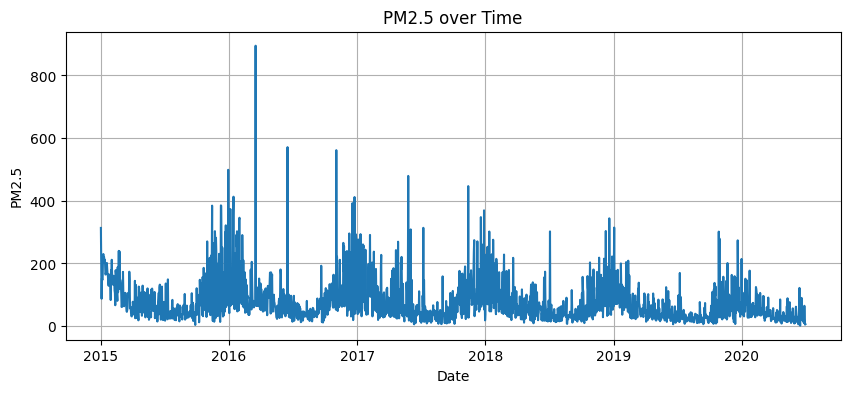


Train size: 1607  Test size: 402

ARIMA Summary:
                                SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1607
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8985.037
Date:                Thu, 23 Oct 2025   AIC                          17976.073
Time:                        12:41:45   BIC                          17992.218
Sample:                    01-01-2015   HQIC                         17982.067
                         - 05-26-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0227      0.021      1.103      0.270      -0.018       0.063
ma.L1         -0.9311      0.009   -100.077      0.000      -0.949      -0.913
s

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jvg_tow/m3_3irjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1jvg_tow/t4507j18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43564', 'data', 'file=/tmp/tmp1jvg_tow/m3_3irjb.json', 'init=/tmp/tmp1jvg_tow/t4507j18.json', 'output', 'file=/tmp/tmp1jvg_tow/prophet_model60n944ah/prophet_model-20251023124146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:41:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:41:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

📊 Model Performance Summary:

               MAE       RMSE
ARIMA    26.451290  40.707224
Prophet  27.357585  39.225185
XGBoost  32.251327  45.383085
LSTM     29.183679  39.616597


<Figure size 800x500 with 0 Axes>

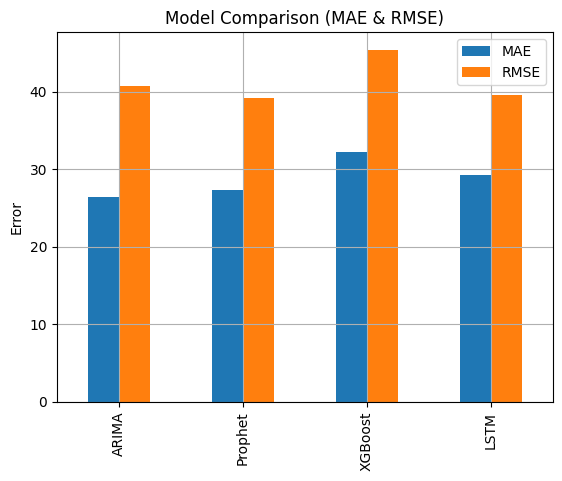


🏆 Best Model: Prophet
✅ Best model saved successfully!

=========== FINAL SUMMARY ===========
Best Model: Prophet
               MAE       RMSE
ARIMA    26.451290  40.707224
Prophet  27.357585  39.225185
XGBoost  32.251327  45.383085
LSTM     29.183679  39.616597


In [3]:
# ======================================
# STEP 0. Unclean Dataset: Load Raw File
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import zipfile

# Load the dataset
# Unzip the file first
zip_file_path = "city_day.csv.zip"
extracted_file_path = "city_day.csv"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

data = pd.read_csv(extracted_file_path)
print("Original Shape:", data.shape)
print(data.head())

# ======================================
# STEP 1. Basic EDA & Data Cleaning
# ======================================
print("\nChecking missing values:")
print(data.isnull().sum())

# Choose target column
target_col = "PM2.5"
date_col = "Date"

# Drop rows where target or Date is missing
data = data.dropna(subset=[target_col, date_col])

# Convert Date column to datetime
data[date_col] = pd.to_datetime(data[date_col])

# Sort by date
data = data.sort_values(date_col)

# Drop 'City' column and keep the first occurrence of each date to remove duplicates
data = data.drop('City', axis=1)
data = data.drop_duplicates(subset=[date_col])

# Fill remaining NaNs with forward fill
data = data.fillna(method="ffill")

# Save cleaned dataset
data.to_csv("clean_city_day.csv", index=False)
print("\n✅ Cleaned dataset saved as 'clean_city_day.csv'")
print("Cleaned Shape:", data.shape)

# ======================================
# STEP 2. EDA Visualization
# ======================================
plt.figure(figsize=(10, 4))
plt.plot(data[date_col], data[target_col])
plt.title(f"{target_col} over Time")
plt.xlabel("Date")
plt.ylabel(target_col)
plt.grid()
plt.show()

# ======================================
# STEP 3. Split into Train/Test
# ======================================
series = data.set_index(date_col)[target_col].asfreq("D").interpolate()

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]
print("\nTrain size:", len(train), " Test size:", len(test))

# ======================================
# STEP 4. Train Models
# ======================================
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import joblib

results = {}

# --- ARIMA ---
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(1,1,1)).fit()
pred_arima = arima_model.forecast(len(test))
mae_arima = mean_absolute_error(test, pred_arima)
rmse_arima = sqrt(mean_squared_error(test, pred_arima))
results['ARIMA'] = {'MAE': mae_arima, 'RMSE': rmse_arima}
print("\nARIMA Summary:\n", arima_model.summary())

# --- Prophet ---
from prophet import Prophet

df_prophet = train.reset_index()
df_prophet.columns = ['ds', 'y']
prophet_model = Prophet()
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)
pred_prophet = forecast['yhat'][-len(test):].values
mae_prophet = mean_absolute_error(test, pred_prophet)
rmse_prophet = sqrt(mean_squared_error(test, pred_prophet))
results['Prophet'] = {'MAE': mae_prophet, 'RMSE': rmse_prophet}

# --- XGBoost ---
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

window = 5
X, y = [], []
for i in range(window, len(series)):
    X.append(series.values[i-window:i])
    y.append(series.values[i])
X, y = np.array(X), np.array(y)
X_train, X_test = X[:train_size-window], X[train_size-window:]
y_train, y_test = y[:train_size-window], y[train_size-window:]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
pred_xgb = xgb_model.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = sqrt(mean_squared_error(y_test, pred_xgb))
results['XGBoost'] = {'MAE': mae_xgb, 'RMSE': rmse_xgb}

# --- LSTM ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

X_lstm = X.reshape((X.shape[0], X.shape[1], 1))
X_train_lstm, X_test_lstm = X_lstm[:train_size-window], X_lstm[train_size-window:]
y_train_lstm, y_test_lstm = y[:train_size-window], y[train_size-window:]

model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(window, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, verbose=0)

pred_lstm = model_lstm.predict(X_test_lstm).flatten()
mae_lstm = mean_absolute_error(y_test_lstm, pred_lstm)
rmse_lstm = sqrt(mean_squared_error(y_test_lstm, pred_lstm))
results['LSTM'] = {'MAE': mae_lstm, 'RMSE': rmse_lstm}

# ======================================
# STEP 5. Compare Models
# ======================================
results_df = pd.DataFrame(results).T
print("\n📊 Model Performance Summary:\n")
print(results_df)

plt.figure(figsize=(8,5))
results_df[['MAE', 'RMSE']].plot(kind='bar')
plt.title("Model Comparison (MAE & RMSE)")
plt.ylabel("Error")
plt.grid()
plt.show()

# ======================================
# STEP 6. Save Best Model
# ======================================
best_model_name = results_df['RMSE'].idxmin()
print(f"\n🏆 Best Model: {best_model_name}")

if best_model_name == 'ARIMA':
    joblib.dump(arima_model, 'best_model.pkl')
elif best_model_name == 'Prophet':
    joblib.dump(prophet_model, 'best_model.pkl')
elif best_model_name == 'XGBoost':
    joblib.dump(xgb_model, 'best_model.pkl')
elif best_model_name == 'LSTM':
    model_lstm.save('best_model.h5')
else:
    print("No best model identified.")

print("✅ Best model saved successfully!")

# ======================================
# STEP 7. Print Final Summary
# ======================================
print("\n=========== FINAL SUMMARY ===========")
print(f"Best Model: {best_model_name}")
print(results_df)